In [1]:
import os
import scipy.io as spio
import numpy as np
from os.path import join, isdir, isfile
%matplotlib inline
import matplotlib.pyplot as plt

# from stack overflow
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]

DATA_DIR = '../data'
# 'file_name' 'class_name' 'class' 'eng' 'mfc' 'chroma' 't'
# 'keystrength' 'brightness' 'zerocross' 'roughness' 'inharmonic' 'hcdf'

FVs = join(DATA_DIR, 'FV.mat')
LBs = join(DATA_DIR, 'LB.mat')
if not isfile(FVs) or not isfile(LBs):
    print('Generating Fisher Vectors')
    !matlab -nodisplay -nosplash -nodesktop -r "run('../tools/FV_concat.m');exit;"
else:
    print('Using existing FVs')

mfcc = np.transpose(spio.loadmat(FVs)['FV'])
labels = spio.loadmat(LBs)['LB'][0]
nlabels = len(set(labels))
assert nlabels == 10
N = mfcc.shape[0]

per_label = N // nlabels
for chunk in chunks(labels, per_label):
     assert(len(set(chunk)) == 1)

N

Using existing FVs


1000

In [6]:
trIdx = np.concatenate([i + np.arange(0, int(per_label * 0.9)) for i in range(0, N, per_label)])
teIdx = np.array([i for i in range(0, N) if i not in set(trIdx)])
np.random.shuffle(trIdx)

trX, trY = mfcc[trIdx], labels[trIdx]
teX, teY = mfcc[teIdx], labels[teIdx]

means = np.mean(trX, axis=0)
stddevs = np.std(trX, axis=0)

def summary(x):
    return '[{:.4f}, {:.4f}]'.format(np.ndarray.min(x), np.ndarray.max(x))
print('means in range', summary(means))
print('std in range', summary(stddevs))

# Whitened data
def adjust(x): return (x - means[None, :]) / stddevs[None, :]
trXadj = adjust(trX)
teXadj = adjust(teX)

print('norm. means in range', summary(np.mean(trXadj, axis=0)))
print('norm. std in range', summary(np.std(trXadj, axis=0)))
trX.shape

means in range [-0.0191, 0.0084]
std in range [0.0205, 0.0616]
norm. means in range [-0.0000, 0.0000]
norm. std in range [1.0000, 1.0000]


(900, 960)

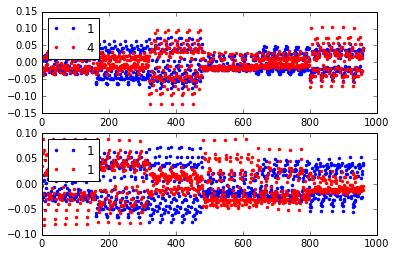

In [38]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
# no missing data
ax1.plot(trX[0], c='b', marker='.', linestyle='', label=trY[0])
ax1.plot(trX[1], c='r', marker='.', linestyle='', label=trY[1])
ax1.legend(loc=2)
same_label = np.where(trY == trY[0])[0][1]
ax2 = fig.add_subplot(212)
# no missing data
ax2.plot(trX[0], c='b', marker='.', linestyle='', label=trY[0])
ax2.plot(trX[same_label], c='r', marker='.', linestyle='', label=trY[same_label])
ax2.legend(loc=2)
plt.show()
# todo riffle

In [39]:
# ovo multi-classification, rbf
from sklearn.svm import SVC
import sklearn
if sklearn.__version__ >= '0.18':
    print('warning, not ovo comparison')
svm = SVC(C=1.0)
svm.fit(trXadj, trY)
print('Accuracies: train {} test {}'.format(svm.score(trXadj, trY), svm.score(teXadj, teY)))

Accuracies: train 0.98 test 0.72


In [ ]:
from sklearn.cross_validation import StratifiedKFold
import itertools

def avg_cv_acc(classifier, K):
    skf = StratifiedKFold(trY,n_folds=len(hypers))
    acc = 0
    for (train_index, test_index) in skf:
        trXcv, trYcv = trXadj[train_index], trY[train_index]
        teXcv, teYcv = trXadj[test_index], trY[test_index]
        classifier.fit(trXcv, trYcv)
        acc += classifier.score(teXcv, teYcv)
    return acc / K

def logRange(lo, hi): return [10 ** i for i in range(lo, hi)]
gammas = [x / len(trX) for x in logRange(-3, 3)]
Cs = logRange(-3, 3)
kernels = ['rbf', 'linear'] # others
hypers = itertools.product(Cs, kernels, gammas)
hypers = ((x[0], x[1], None) if x[1] == 'linear' else x for x in hypers)
hypers = (k for k, g in itertools.groupby(hypers))
hypers = list(hypers)
print(hypers)

def make_svc(tup): return SVC(C=tup[0], kernel=tup[1], gamma=tup[2])

best_params = None
best_acc = -np.inf
for tup in hypers:
    acc = avg_cv_acc(make_svc(tup), 4)
    if acc > best_acc:
        best_acc = acc
        best_params = tup
        
svm = make_svc(best_params)

print('Accuracies: cv {} (best C = {}, kernel = {}, gamma = {})'.format(
         best_acc, *best_params))
svm.fit(trXadj, trY)
print('  re-trained test {}'.format(svm.score(teXadj, teY)))

In [17]:
from sklearn.svm import LinearSVC

Cs = [10 ** i for i in range(-4, 5)]
skf = StratifiedKFold(trY,n_folds=len(Cs))
best_score, best_model, best_c = -np.inf, None, None
for (train_index, test_index), C in zip(skf, Cs):
    trXcv, trYcv = trXadj[train_index], trY[train_index]
    teXcv, teYcv = trXadj[test_index], trY[test_index]
    svm = LinearSVC(C=C, penalty='l1', dual=False)
    svm.fit(trXcv, trYcv)
    score = svm.score(teXcv, teYcv)
    if score > best_score:
        best_score = score
        best_c = C
        best_model = svm
        
svm = best_model

print('Accuracies: cv {} (best C = {})'.format(
         best_score, best_c))
svm.fit(trXadj, trY)
print('  re-trained test {}'.format(svm.score(teXadj, teY)))

Accuracies: cv 0.63 (best C = 1000)
  re-trained test 0.55


In [6]:
# Stanford mSVM http://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html
# This requires a new convex program formulation, unsupported within-python.

In [61]:
import sys
from joblib import Parallel, delayed

class DummyPredictor:
    def __init__(self, res):
        self._res = res
    def predict(self, X):
        Y = np.empty([len(X), 1])
        Y.fill(self._res)
        return Y
        
def find_best(subsets, X, origY, C):
    best_accuracy, best_classifier, best_set = -np.inf, None, None
    val = int(0.8 * len(X))
    for subset in subsets:
        Y = np.array([y in subset for y in origY])
        svm = SVC(C=C).fit(X[:val], Y[:val])
        acc = svm.score(X[val:], Y[val:])
        if acc > best_accuracy:
            best_accuracy = acc
            best_classifier = svm
            best_set = subset
    return best_accuracy, best_classifier, best_set
    
def best_subset_finder(labels, C=1.0):
    assert len(labels) > 0
    if len(labels) == 1:
        return {}, DummyPredictor(next(iter(labels))), {}
    if len(labels) == 2:
        return {}, SVC(C=C).fit(trXadj, trY), {}
    
    subsets = []
    for i in range(1, len(labels) // 2 + 1):
        for subset in itertools.combinations(labels, i):
            subsets.append(subset)
    p = np.random.permutation(len(trXadj))
    pX = trXadj[p]
    pY = trY[p]
    
    nproc = 4
    print('  Launching {} parallel tasks for {} problems.'.format(nproc, len(subsets)))
    sys.stdout.flush()
    np.random.shuffle(subsets)
    
    best_parallel = Parallel(n_jobs=2, backend='threading') \
        (delayed(find_best)(i, pX, pY, C) for i in chunks(subsets, max(len(subsets) // nproc, 1)))
    best_accuracy, best_set, best_classifier = -np.inf, None, None
    for job_best_acc, job_best_classifier, job_best_set in best_parallel:
         if job_best_acc > best_accuracy:
             best_accuracy = job_best_acc
             best_classifier = job_best_classifier
             best_set = set(job_best_set)
         
    other = labels - best_set
    print('  Split on 0/1 for {} vs {}, validation acc {}'.format(
        best_set, other, best_accuracy))
    sys.stdout.flush()
    assert best_classifier
    return best_set, best_classifier, other

class DTree(object):
    def __init__(self, classifier, lset, rset):
        self.lset = lset
        self.rset = rset
        self.left = None
        self.right = None
        self.classifier = classifier

def binary_dtree(labels, C=10.0, debug_print_level=None):
    dbp = debug_print_level
    if dbp: print('Level {}'.format(dbp))
    left, svm, right = best_subset_finder(labels)
    if not left: assert not right
    x = DTree(svm, left, right)
    if not left: return x
    x.left = binary_dtree(left, C=(C * len(left) / len(labels)),
                          debug_print_level=(dbp + '0' if dbp else None))
    x.right = binary_dtree(right, C=(C * len(right) / len(labels)),
                           debug_print_level=(dbp + '1' if dbp else None))
    return x

In [62]:
bdt = binary_dtree(set(trY), C=10.0, debug_print_level='r')

Level r
  Launching 4 parallel tasks for 627 problems.
  Split on 0/1 for {2, 7} vs {1, 3, 4, 5, 6, 8, 9, 10}, validation acc 0.96875
Level r0
Level r1
  Launching 4 parallel tasks for 154 problems.
  Split on 0/1 for {1, 3} vs {4, 5, 6, 8, 9, 10}, validation acc 0.9125
Level r10
Level r11
  Launching 4 parallel tasks for 41 problems.
  Split on 0/1 for {9} vs {8, 10, 4, 5, 6}, validation acc 0.9625
Level r110
Level r111
  Launching 4 parallel tasks for 15 problems.
  Split on 0/1 for {8} vs {10, 4, 5, 6}, validation acc 0.975
Level r1110
Level r1111
  Launching 4 parallel tasks for 10 problems.
  Split on 0/1 for {5} vs {10, 4, 6}, validation acc 0.9375
Level r11110
Level r11111
  Launching 4 parallel tasks for 3 problems.
  Split on 0/1 for {6} vs {10, 4}, validation acc 0.93125
Level r111110
Level r111111


In [63]:
#What if we retrain on the whole training dataset?
def dtree_predict(dt, x):
    y = dt.classifier.predict([x])[0]
    if not dt.left: return y
    subtree = dt.left if y else dt.right
    return dtree_predict(subtree, x)

def vec_dtree_predict(dt, X):
    return np.array([dtree_predict(dt, x) for x in X])

np.sum(vec_dtree_predict(bdt, teXadj) == teY) / len(teY)

0.625